# DESeq2 in python using rpy2

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np

We will read the table and it should only contains count data

In [2]:
directory = "../topics/unified/"
L = 3
filename = f"{directory}/topsbm/topsbm_level_{L}_topic-dist.csv"
df = pd.read_csv(filename, index_col=1).drop("i_doc", axis=1)
df = df.subtract(df.mean(0),1)
df = df.add(df.min(0).abs(),1)
df=df.transpose().reset_index()
df.rename({"index":"id"}, axis=1, inplace=True)
df.set_index("id", inplace=True)
df=df.applymap(lambda p: round(p*1000)+1).astype(int)
df.reset_index(inplace=True)
print(df.shape)
df.head()

(315, 801)


doc,id,TCGA-B6-A0RV-01A-11R-A084-07,TCGA-BH-A1EU-01A-11R-A137-07,TCGA-E9-A1RB-11A-33R-A157-07,TCGA-B6-A0RS-01A-11R-A084-07,TCGA-A8-A06N-01A-11R-A00Z-07,TCGA-AR-A2LL-01A-11R-A180-07,TCGA-BH-A0HL-01A-11R-A10U-07,TCGA-A8-A09Q-01A-11R-A00Z-07,TCGA-BH-A1FR-01A-11R-A13Q-07,...,GTEX-12WSG-2126-SM-5EGJ7,GTEX-1117F-2426-SM-5EGGH,GTEX-12ZZX-2126-SM-5LZVL,GTEX-POMQ-1226-SM-3P61F,GTEX-11EM3-1926-SM-5987U,GTEX-ZLWG-1026-SM-4WWC4,GTEX-UPIC-1526-SM-4IHLU,GTEX-145ME-1326-SM-5O98Q,GTEX-T2IS-2226-SM-4DM65,GTEX-1399S-2226-SM-5IFEW
0,Topic 1,27,43,41,33,22,39,14,38,27,...,32,9,23,41,23,39,27,16,30,76
1,Topic 2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
2,Topic 3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Topic 4,1,1,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,Topic 5,2,3,2,6,2,2,4,3,3,...,3,3,3,3,5,6,3,3,3,3


And here, we will create a design matrix based on the samples in the count table. Note that the sample name has to be used as the ```pd.DataFrame``` index

In [10]:
#sample_df = pd.DataFrame({'samplename': df.columns}) \
#        .query('samplename != "id"')\
#        .assign(sample = lambda d: d.samplename.str.extract('([AB])_', expand=False)) \
#        .assign(replicate = lambda d: d.samplename.str.extract('_([123])', expand=False)) 
sample_df = pd.read_csv(f"{directory}/files.dat", index_col=0)
sample_df["file_name"] = sample_df.index
label = "status"
sample_df=sample_df.reindex(columns=["file_name", label])

sample_df.set_index("file_name", inplace=True)
sample_df=sample_df[sample_df.index.isin(df.columns)]

print(np.unique(sample_df[label],return_counts=True))
tissue = sample_df[label].unique()[0]
print(tissue)

sample_df["treat"]=["A" if tissue in str(d) else "B" for d in sample_df[label]]
sample_df = sample_df.reindex(index=df.columns, columns=["treat"]).dropna(how="any", axis=0)
#df=df.reindex(columns=np.concatenate([["id"],df.columns[df.columns.isin(sample_df.index)]])).dropna(how="any", axis=0)
sample_df.head()

(array(['healthy', 'tumor'], dtype=object), array([451, 349]))
tumor


,treat
doc,
TCGA-B6-A0RV-01A-11R-A084-07,A
TCGA-BH-A1EU-01A-11R-A137-07,A
TCGA-E9-A1RB-11A-33R-A157-07,B
TCGA-B6-A0RS-01A-11R-A084-07,A
TCGA-A8-A06N-01A-11R-A00Z-07,A


Running DESeq2 is jsut like how it is run in ```R```, but instead of the row.name being gene ID for the count table, we can jsut tell the function which column is the gene ID:

In [11]:
import sys
sys.path.append("./diffexpr/")

In [12]:
#df=pd.DataFrame(columns=["id", "s1","s2","s3"], data=[["g1",1,1,1],["g2",2,3,3]])
#sample_df = pd.DataFrame(columns=["subtype"], index=["s1","s2","s3"], data=["A","B","B"])

In [13]:
from diffexpr.py_deseq import py_DESeq2

dds = py_DESeq2(count_matrix = df,
               design_matrix = sample_df,
               design_formula = '~ treat',
               gene_column = 'id') # <- telling DESeq2 this should be the gene ID column
    
dds.run_deseq() 
dds.get_deseq_result()
res = dds.deseq_result 
res.head()





   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,id
Topic 1,49.643410,0.082119,0.079312,1.035392,3.004859e-01,4.674225e-01,Topic 1
Topic 2,5.061009,-0.824337,0.149545,-5.512300,3.541754e-08,1.847268e-07,Topic 2
Topic 3,1.899734,0.611664,0.105904,5.775652,7.665588e-09,4.432710e-08,Topic 3
Topic 4,3.508483,0.718550,0.129759,5.537580,3.066799e-08,1.631537e-07,Topic 4
Topic 5,2.916595,0.288115,0.067258,4.283704,1.838073e-05,7.521959e-05,Topic 5


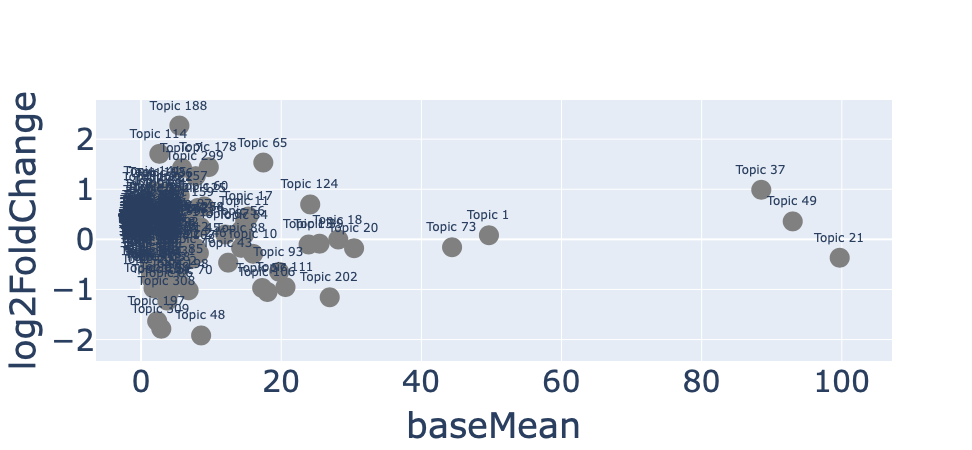

In [14]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=res["baseMean"],
                         y=res["log2FoldChange"],
                         mode="markers+text",
                         marker={"size":20, "color":"gray"}, 
                         text=res.index,
                         textposition="top center")
             )
#for (x,y, name) in zip(res["baseMean"],res["log2FoldChange"],res.index):
    #plt.annotate(name,xy=(x,y))
    
layout = {}
layout["xaxis"]={}
layout["xaxis"]["title"]="baseMean"
layout["xaxis"]["titlefont_size"]=35
layout["xaxis"]["tickfont_size"]=30
layout["yaxis"]={}
layout["yaxis"]["title"]="log2FoldChange"
layout["yaxis"]["titlefont_size"]=35
layout["yaxis"]["tickfont_size"]=30
fig.update_layout(layout)
fig.show()
fig.write_image(f"{directory}/topsbm/desqe2_level{L}_{tissue}.pdf")

In [15]:
list(map(lambda g: print(g[:15]),pd.read_csv(f'{directory}/topsbm/topsbm_level_{L}_topics.csv')["Topic 197"].dropna()))

DLK1
MYL1
CKM
COL9A3
MYH7
CSRP3
MYH6


[None, None, None, None, None, None, None]

In [ ]:
dds.normalized_count() #DESeq2 normalized count

In [ ]:
dds.comparison # show coefficients for GLM

In [ ]:
# from the last cell, we see the arrangement of coefficients, 
# so that we can now use "coef" for lfcShrink
# the comparison we want to focus on is 'sample_B_vs_A', so coef = 4 will be used
lfc_res = dds.lfcShrink(coef=2, method='apeglm')
lfc_res.head()

In [ ]:
dds.deseq_result